<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/shape_placement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo
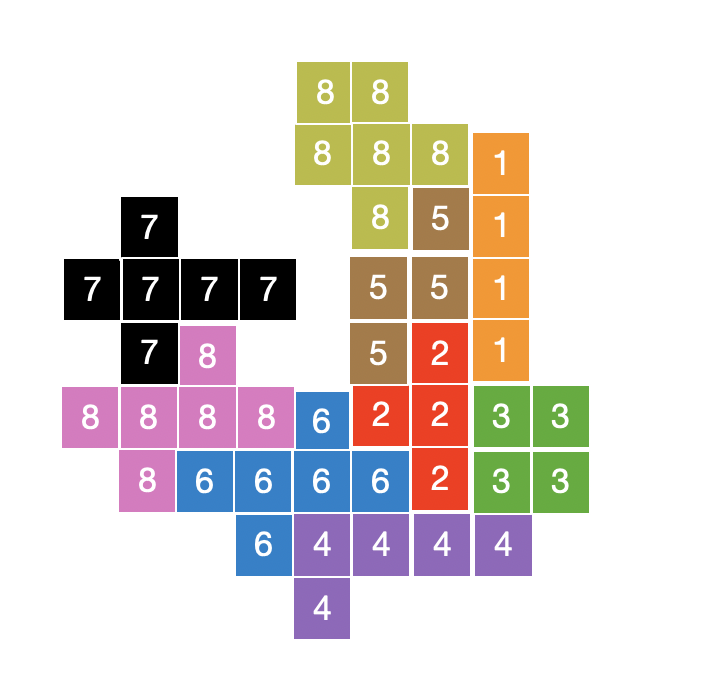

In [ ]:
!pip install ortools
import numpy as np
from random import randint
import random
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt # Data visualization
from matplotlib.patches import Rectangle
from ortools.sat.python import cp_model as cp


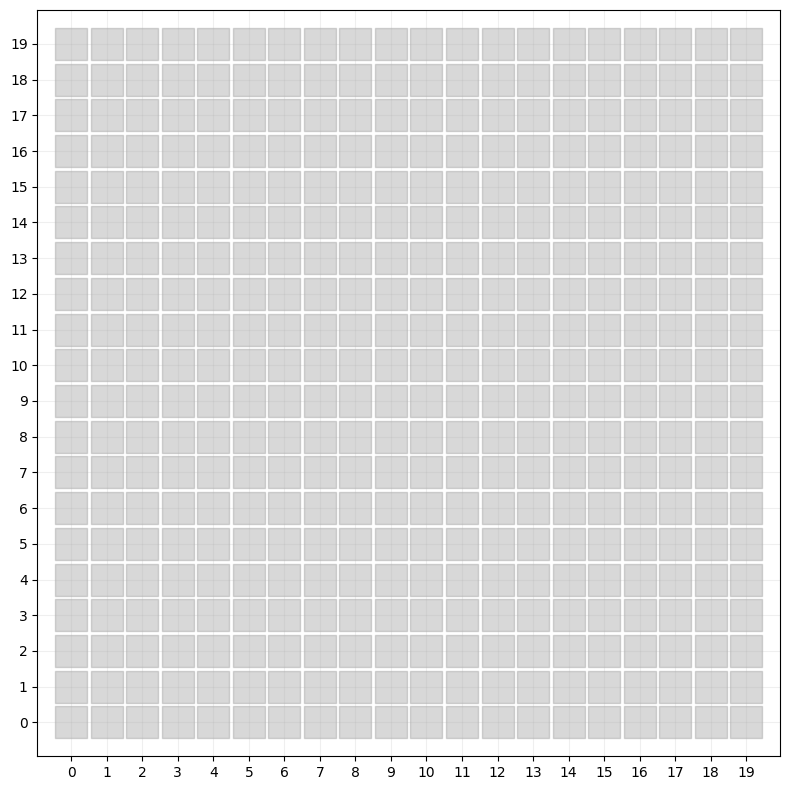

In [ ]:
nx , ny = 20 , 20
counter = 0
location = {}
for i in range(nx):
  for j in range(ny):
    counter +=1
    location[counter,'x'] = i
    location[counter,'y'] = j
cells = range(1,1+counter)
loc2cell = {(location[cell,'x'],location[cell,'y']):cell for cell in cells}


shapes = {1: [(0,0),(0,-1),(0,-2),(0,-3)],
          2: [(0,0),(1,0),(1,1),(0,1)],
          3: [(0,0),(1,0),(1,1),(1,-1)],
          4: [(0,0),(0,1),(1,1),(2,1)],
          5: [(0,0),(0,1),(1,1),(1,2)],
          6: [(0,0),(1,0),(2,0),(3,0),(1,-1), (2,1)],
          7: [(0,0),(1,0),(2,0),(3,0),(1,-1), (1,1)],
          8: [(0,0),(1,0),(2,0),(0,1),(1,-1), (1,1)],
}

plt.figure(figsize=(8,8))
for i in cells:
  x,y = location[i,'x'], location[i,'y']
  plt.scatter(x,y, s=500, c= 'grey', marker= 's', alpha=0.3)
  plt.xticks(range(nx))
  plt.yticks(range(ny))
  plt.grid(alpha=0.2, zorder=-1)
  plt.tight_layout()



In [ ]:
KOLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
            "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
            "#8c6d31", "#9c9ede", "#637939", "#e7cb94", "#b5cf6b",
            "#cedb9c", "#c7c7c7", "#bd9e39", "#e7969c", "#7b4173"]

def dist(i,j):
  x0, y0 = location[i,'x'], location[i,'y']
  x1, y1 = location[j,'x'], location[j,'y']
  return (x0-x1)**2 +(y0-y1)**2


list1 = [1,3,4]

list2 = [2,3,4]

def check_nb(list1,list2):
  list1 = set(list1)
  list2 = set(list2)

  s1 = list1- list2
  s2 = list2- list1

  if len(s1)*len(s2) == 0:
    return False
  else:
    for i in s1:
      for j in s2:
        if dist(i,j)<=2:
          return True


print(list1,list2)
check_nb(list1,list2)

[1, 3, 4] [2, 3, 4]


True

FEASIBLE
NumConflicts: 0
NumBranches: 1608
WallTime: 180.149022392
OF =  54.0
1 44
2 44
3 44
4 44
5 44
6 42
7 42
8 42


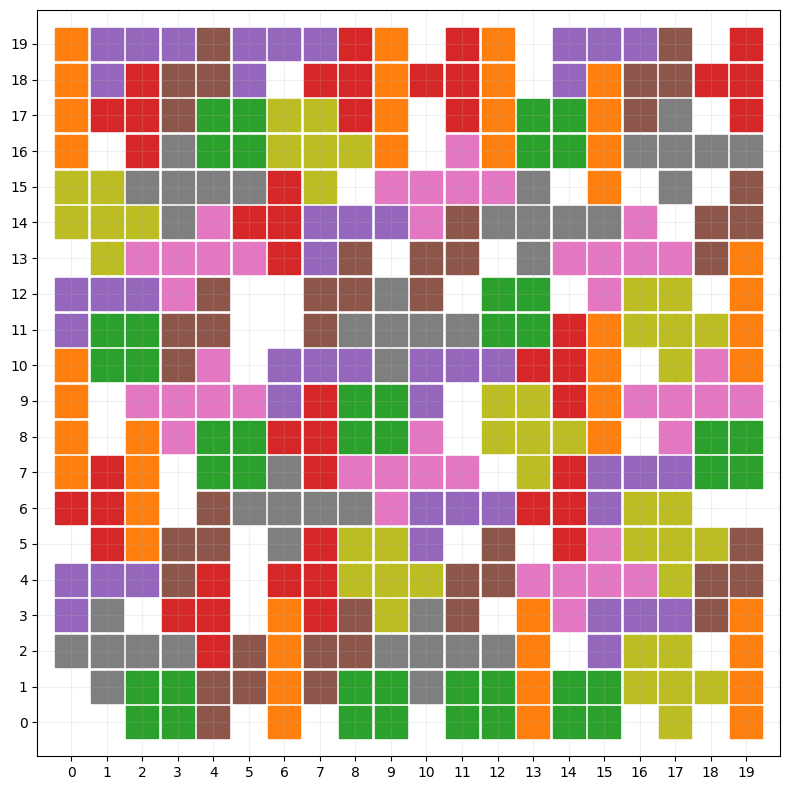

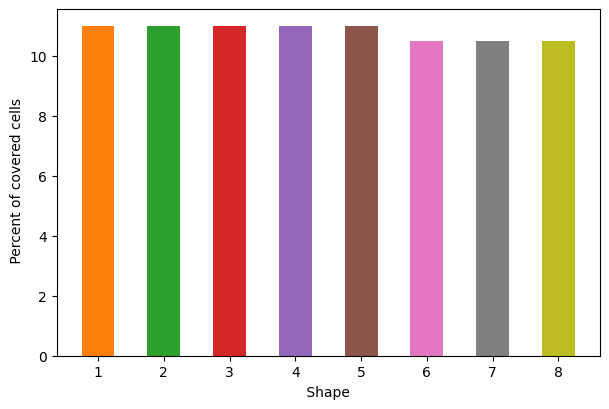

In [ ]:

def main():
  model = cp.CpModel()
  pieces = shapes.keys()
  U = {(i,p): model.NewBoolVar(f"U_{i,p}") for i in cells for p in pieces if
       all([ (location[i,'x']+xp, location[i,'y']+yp) in loc2cell
            for (xp,yp) in shapes[p]])
       }
  C = {i: model.NewBoolVar(f"C_{i}") for i in cells}
  data_neighbors = {}
  for (i,p),v in U.items():
    data_neighbors[i,p] = [loc2cell[location[i,'x']+xp, location[i,'y']+yp] for (xp,yp) in shapes[p]]
    model.Add(C[i]==1).OnlyEnforceIf(v)


  for p1 in pieces:
    for p2 in pieces:
      if p1>p2:
        expressions_p1 = [len(shapes[p])*v for (i,p),v in U.items() if p==p1]
        expressions_p2 = [len(shapes[p])*v for (i,p),v in U.items() if p==p2]
        model.AddLinearConstraint( cp.LinearExpr.Sum(expressions_p1)- cp.LinearExpr.Sum(expressions_p2) ,-5,5)

  # neighbours should not have the same color
  for (i,pi), nb_i in data_neighbors.items():
    for (j,pj), nb_j in data_neighbors.items():
      if i>j and pi == pj and (i,pi) in U and (j,pj) in U and check_nb(nb_i,nb_j):
        model.AddAtMostOne([U[i,pi] , U[j,pj]])




  for i in cells:
    expressions = [U[n,p] for (n,p),hamsadeh in data_neighbors.items() if i in hamsadeh and (n,p) in U]
    model.Add(C[i]== cp.LinearExpr.Sum(expressions) )

  not_covered = [v.Not() for i,v in C.items()]

  for p in pieces:
    expressions = [U.get((i,p),0) for i in cells]
    model.Add(cp.LinearExpr.Sum(expressions) >= 2)

  model.Minimize(cp.LinearExpr.Sum(not_covered) )
  solver = cp.CpSolver()
  solver.parameters.num_workers = 16
  solver.parameters.max_time_in_seconds = 180
  status = solver.Solve(model)
  if status == cp.OPTIMAL:
    print("OPTIMAL")
  elif status == cp.INFEASIBLE:
    print("INFEASIBLE")
  elif status == cp.FEASIBLE:
    print("FEASIBLE")
  elif status == cp.UNKNOWN:
    print("UNKNOWN")

  # print("num_solutions:", num_solutions)
  print("NumConflicts:", solver.NumConflicts())
  print("NumBranches:", solver.NumBranches())
  print("WallTime:", solver.WallTime())
  print("OF = ", solver.ObjectiveValue())

  plt.figure(figsize=(8,8))
  for (i,p),v in U.items():
    if solver.value(v)>0:
      #print("TAG", i,p)
      aa= 20+random.randint(20,80)
      x,y = location[i,'x'], location[i,'y']
      plt.scatter(x,y, s=500, c= KOLORS[p], marker= 's')
      for k in data_neighbors[i,p]:
        if k !=i:
          x,y = location[k,'x'], location[k,'y']
          plt.scatter(x,y, s=500, c= KOLORS[p], marker= 's')

  report = {}
  for p1 in pieces:
    expressions_p1 = [len(shapes[p])*solver.value(v) for (i,p),v in U.items() if p==p1]
    print(p1,sum(expressions_p1))
    report[p1] = sum(expressions_p1)

  plt.xticks(range(nx))
  plt.yticks(range(ny))
  plt.grid(alpha=0.2, zorder=-1)
  plt.tight_layout()

  plt.figure(figsize=(6,4))

  for p1 in pieces:
    plt.bar(p1,100*report[p1]/(nx*ny),width=0.5 , color = KOLORS[p1])
  plt.tight_layout()
  plt.xlabel(" Shape ")
  plt.ylabel(" Percent of covered cells")

if __name__ == "__main__":
  main()